In [200]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage

from skimage import measure

In [201]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
#path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"
#model = load_model(path + 'models/' + 'EDGEnet_run_epoch_4.h5')

model = load_model(path + 'models/' + 'Linenet_run1_epoch_4.h5')

In [202]:
sigma = 1.2
alpha = 0.2
Xi = 10
width = 30
space = 30
noise = 2
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

original_file = path + 'original_images/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

im = np.array(Image.open(original_file))
im = im/256

imnoisy = np.array(Image.open(noisy_file))
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)

predict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
predict = predict.reshape(1024,64,2)
#predict[:,:,1] = predict[:,:,1] > 0.9

9.90334402893
22.6676070794


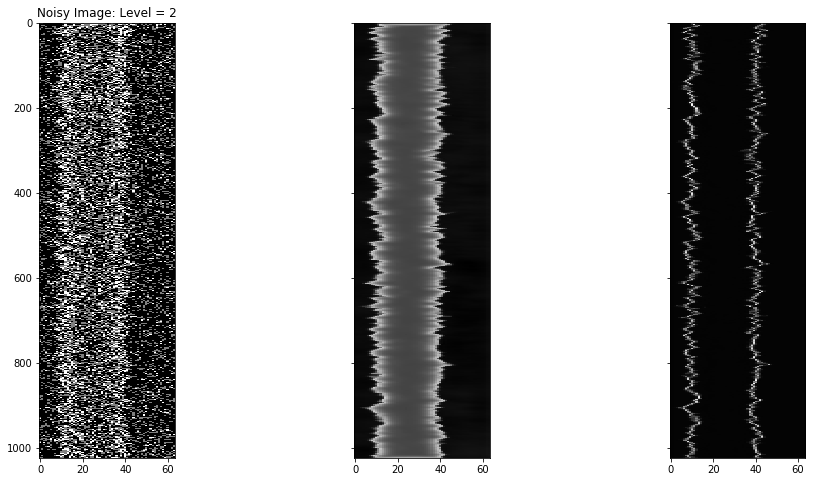

In [203]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

print(measure.compare_psnr(im,imnoisy.astype(float)))
print(measure.compare_psnr(im,predict[:,:,0].astype(float)))

ax[0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0].set_title('Noisy Image: Level = {}'.format(noise))

    
ax[1].imshow(predict[:,:,0], cmap = 'gray',aspect= 0.2)

ax[2].imshow(predict[:,:,1], cmap = 'gray',aspect= 0.2)

plt.show()


In [210]:
predict[:,:,1] = predict[:,:,1] > 0.4
leftline_pred = np.argmax(predict[:,:,1],axis = 1)
rightline_pred = np.argmax(np.fliplr(predict[:,:,1]),axis = 1)
rightline_pred = 63 - rightline_pred
print(rightline_pred.shape)

(1024,)


Original leftline sigma = 1.0270276181557094, rightline sigma = 0.9943812590569311
Predicted leftline sigma = 0.9057993590561748, rightline sigma = 1.273057658643486
985
1078


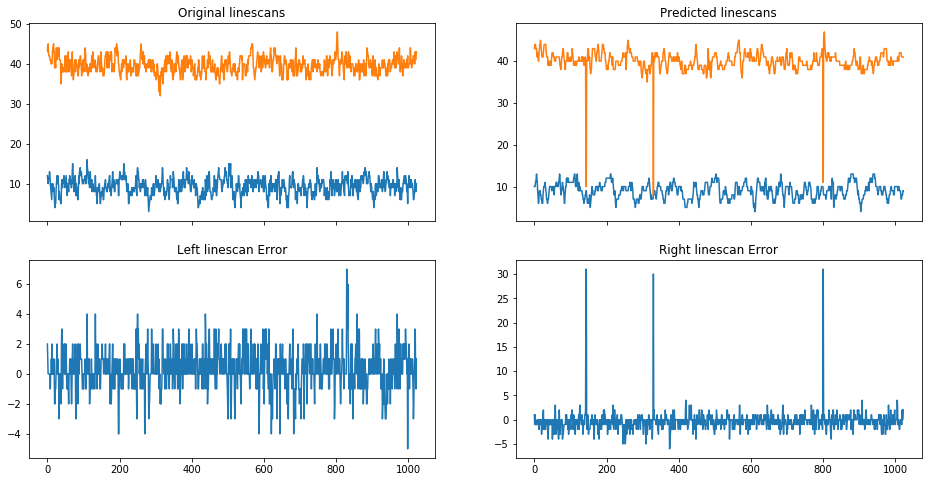

In [211]:
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

print('Original leftline sigma = {}, rightline sigma = {}'.format(leftline.astype(int).std()/2, \
                                                                  rightline.astype(int).std()/2))

print('Predicted leftline sigma = {}, rightline sigma = {}'.format(leftline_pred.std()/2, \
                                                                  rightline_pred.std()/2))

print(np.abs(leftline.astype(int) - leftline_pred).sum())
print(np.abs(rightline.astype(int) - rightline_pred).sum())

ax[0,0].plot(leftline.astype(int))
ax[0,0].plot(rightline.astype(int))
ax[0,0].set_title('Original linescans')

ax[0,1].plot(leftline_pred)
ax[0,1].plot(rightline_pred)
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.astype(int) - leftline_pred)
ax[1,0].set_title('Left linescan Error')

ax[1,1].plot(rightline.astype(int) - rightline_pred)
ax[1,1].set_title('Right linescan Error')
plt.show()

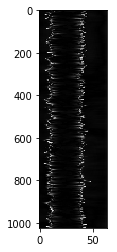

In [212]:
plt.imshow(np.abs(im - predict[:,:,0]), cmap = 'gray',aspect= 0.2)
plt.show()